# fused softmax op significantly faster than torch native op 
# matrices: whose rows can fit in the GPU's SRAM
# kernel fusion for bandwidth-bound operations

In [5]:
import torch as T
import triton
import triton.language as tl
from triton.runtime import driver

In [2]:
# DEVICE = triton.runtime.driver.active.get_active_torch_device()
def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"
def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in \
        ('gfx940', 'gfx941', 'gfx942', 'gfx90a', 'gfx908')


# requires reading `5MN + 2M` elements from DRAM and writing back `3MN + 2M` elements
# prefer to have a custom "fused" kernel that only reads X once and does all necessary compute on-chip
# would require reading and writing back only `MN` bytes
# expect a theoretical speed-up of ~4x (`(8MN + 4M) / 2MN`)
# `torch.jit.script` flags aims to perform this kind of "kernel fusion" automatically

In [3]:
def naive_softmax(x: T.Tensor) -> T.Tensor:
    x_max = x.max(dim = 1)[0]
    overflow_safe_x = x - x_max[:, None]
    numerator = T.exp(overflow_safe_x)
    denominator = numerator.sum(dim = 1)
    sum = numerator / denominator[:, None]
    return sum

# Triton kernel implementation:
# each program loads a set of rows of the input matrix X strided by number of programs,
# normalizes it and writes back the result to the output Y.
#
# Note that one important limitation of Triton is that each block must have a
# power-of-two number of elements, so we need to internally "pad" each row and guard the
# memory operations properly if we want to handle any possible input shapes:

In [11]:
@triton.jit
def _softmax_fwd_kernel(
  output_ptr: tl.tensor, stride_output_row: tl.constexpr, \
    input_ptr: tl.tensor, stride_input_row: tl.constexpr, num_cols: tl.constexpr, \
      block_size: tl.constexpr) -> None: 
    # input params
    row_index = tl.program_id(0)
    row_start_ptr = input_ptr + (row_index * stride_input_row)
    col_offsets = tl.arange(0, block_size)
    input_pointers = row_start_ptr + col_offsets
    row_mask = col_offsets < num_cols
    
    # move to SRAM
    row: tl.tensor = tl.load(input_pointers, mask = row_mask, other = float("-inf")) 
    
    # softmax
    max_row: tl.float32 = tl.max(row, axis = 0)
    safe_row: tl.tensor = row - max_row
    numerator: tl.tensor = tl.exp(safe_row)
    denominator: tl.float32 = tl.sum(numerator, axis = 0)
    sm_out: tl.tensor = numerator / denominator

  # write back to HBM
    output_row_ptr = output_ptr + (row_index * stride_output_row)
    output_pointers = output_row_ptr + col_offsets
    tl.store(output_pointers, sm_out, mask = row_mask)


def tl_softmax(x: T.Tensor) -> T.Tensor:
    # forward pass
    rows, cols = x.shape
    assert x.dim() == 2, f"accepts 2D t ensors only"
    block_size: int = triton.next_power_of_2(cols)
    num_warps: int = 4
    if block_size > 2047: num_warps = 8
    if block_size > 4095: num_warps=16
    grid = (rows,)

  # allocate our output buffer
    sm_out: T.Tensor = T.empty_like(x)
    _softmax_fwd_kernel[grid](sm_out, sm_out.stride(0), x, \
        x.stride(0), cols, block_size = block_size, num_warps = num_warps
    )
    return sm_out


In [9]:
sample = T.tensor([[23, 33, 77, 89, 12], [99, 46, 65, 11, 13]], \
    dtype = T.float32, device = 'cuda')

In [12]:
ref_out = T.softmax(sample, dim = 1)
eager_out = naive_softmax(sample)
triton_out = tl_softmax(sample)

print("Ref Out = ", ref_out)
print("Eager Out = ", eager_out)
print("Triton Out = ", triton_out)

Ref Out =  tensor([[2.1705e-29, 4.7809e-25, 6.1442e-06, 9.9999e-01, 3.6251e-34],
        [1.0000e+00, 9.6027e-24, 1.7139e-15, 6.0546e-39, 4.4738e-38]],
       device='cuda:0')
Eager Out =  tensor([[2.1705e-29, 4.7809e-25, 6.1442e-06, 9.9999e-01, 3.6251e-34],
        [1.0000e+00, 9.6027e-24, 1.7139e-15, 6.0546e-39, 4.4738e-38]],
       device='cuda:0')
Triton Out =  tensor([[2.1705e-29, 4.7809e-25, 6.1442e-06, 9.9999e-01, 3.6251e-34],
        [1.0000e+00, 9.6027e-24, 1.7139e-15, 6.0546e-39, 4.4738e-38]],
       device='cuda:0')


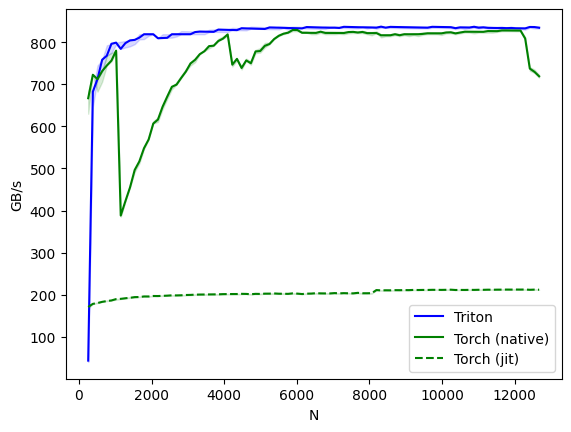

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0   43.115788      667.033088   170.666661
1     384.0  682.666643      722.823517   178.086953
2     512.0  712.347810      712.347810   180.043953
3     640.0  758.518517      731.428561   182.857140
4     768.0  768.000002      744.727267   184.781963
5     896.0  796.444416      756.392391   186.181826
6    1024.0  799.219525      780.190482   189.410412
7    1152.0  784.340403      388.042093   190.020625
8    1280.0  798.003020      422.268057   191.401869
9    1408.0  804.571418      455.111124   192.547003
10   1536.0  805.770507      496.484863   194.132812
11   1664.0  811.011925      516.735733   194.335773
12   1792.0  819.199978      548.090782   195.713317
13   1920.0  819.199961      568.888888   195.668787
14   2048.0  819.200021      606.814814   196.804803
15   2176.0  809.674419      616.212379   196.700571
16   2304.0  810.197787      646.736830   197.133692
17   2432.0  810.666638  

In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names = ['N'],  # args to use as an x-axis
        x_vals = [128 * i for i in range(2, 100)], # possible values for `x_name`
        line_arg = 'provider',  # arg whose value corresponds to different line in the plot
        line_vals = ['triton', 'torch-native', 'torch-jit'],
        line_names = ["Triton", "Torch (native)", "Torch (jit)"],  # label name for the lines
        styles = [('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel = "GB/s",  # label name for the y-axis
        plot_name = "softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args = {'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = T.randn(M, N, device = 'cuda', dtype = T.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = \
            triton.testing.do_bench(lambda: T.softmax(x, axis = -1), quantiles = quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = \
            triton.testing.do_bench(lambda: tl_softmax(x), quantiles = quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = \
            triton.testing.do_bench(lambda: naive_softmax(x), quantiles = quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots = True, print_data = True)